In [1]:
!pip install scikit-learn matplotlib pandas seaborn numpy imblearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.3/258.3 kB 2.7 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, mean_squared_error,
                             mean_absolute_error,
                             r2_score, precision_recall_curve, roc_curve, auc)
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
from scipy.stats import zscore
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from collections import OrderedDict
from imblearn.over_sampling import SMOTE

import zipfile
import os

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Load the JSON file
data = pd.read_csv('/content/drive/My Drive/processed_data.csv')

In [5]:
data.head()

,MONTH,DAY_OF_WEEK,DEP_DEL15,DEP_TIME_BLK,DISTANCE_GROUP,SEGMENT_NUMBER,CONCURRENT_FLIGHTS,NUMBER_OF_SEATS,CARRIER_NAME,AIRPORT_FLIGHTS_MONTH,...,DEPARTING_AIRPORT,LATITUDE,LONGITUDE,PREVIOUS_AIRPORT,PRCP,SNOW,SNWD,TMAX,AWND,PART_OF_DAY
0,1,7,0,0800-0859,1,2,25,143,Southwest Airlines Co.,13056,...,McCarran International,36.08,-115.152,Phoenix Sky Harbor International,0.0,0.0,0.0,65.0,2.91,2
1,1,7,0,1200-1259,1,2,26,143,Southwest Airlines Co.,13056,...,McCarran International,36.08,-115.152,San Francisco International,0.0,0.0,0.0,65.0,2.91,3
2,1,7,0,0800-0859,2,2,25,143,Southwest Airlines Co.,13056,...,McCarran International,36.08,-115.152,Salt Lake City International,0.0,0.0,0.0,65.0,2.91,2
3,1,7,0,1000-1059,2,2,29,143,Southwest Airlines Co.,13056,...,McCarran International,36.08,-115.152,Orange County,0.0,0.0,0.0,65.0,2.91,2
4,1,7,0,0900-0959,2,2,28,143,Southwest Airlines Co.,13056,...,McCarran International,36.08,-115.152,Portland International,0.0,0.0,0.0,65.0,2.91,2


In [6]:
data.isnull().sum()

,0
MONTH,0
DAY_OF_WEEK,0
DEP_DEL15,0
DEP_TIME_BLK,0
DISTANCE_GROUP,0
SEGMENT_NUMBER,0
CONCURRENT_FLIGHTS,0
NUMBER_OF_SEATS,0
CARRIER_NAME,0
AIRPORT_FLIGHTS_MONTH,0


In [7]:
data.isna().sum()

,0
MONTH,0
DAY_OF_WEEK,0
DEP_DEL15,0
DEP_TIME_BLK,0
DISTANCE_GROUP,0
SEGMENT_NUMBER,0
CONCURRENT_FLIGHTS,0
NUMBER_OF_SEATS,0
CARRIER_NAME,0
AIRPORT_FLIGHTS_MONTH,0


#**Feature Engineering**

###**IMPORTANT**
####Delayed and non-delayed values have to be equally distributed for good training
================================================================================

*   **Part of Day**: useful, good distribution against delay (night)
*   **Average Flight by Month**: might be useful, good distribution against delay
*   **Wind speed**: indecisive, overlapping with peaks (experiment)
*   **Snow**: good distribution
*   **Concurrent flights**: useful, good  distribution
*   **Segment Num**: good correlation, decent distribution
*   **Percipitation**: indecisive? somewhat correlated, but no significant patterns
*   **Plane age**: same as percipitation
*   **Distance Group**: Good distribution, data pattern
*   **Previous Airport**: Great distribution
--------------------------------------------------------------------------------
*   Num of Seats: Not too informative, few bars shown only
*   Day of Week: not useful since no significant distribution
*   TMAX: not useful, most important feature for RF, might be impacting negatively
*   Depth of Snow: Not really useful, most data in 0
*   Num of flights by Airport: better to remove - unequal distribution lead to overfit
*   Previous Airport: Null value so no, visualise to prove

In [8]:
columns = [
    'DEP_DEL15', 'PART_OF_DAY', 'DISTANCE_GROUP',
    'CONCURRENT_FLIGHTS', 'DEPARTING_AIRPORT', 'PREVIOUS_AIRPORT',
    'MONTH', 'PLANE_AGE', 'SEGMENT_NUMBER',
    'PRCP', 'SNOW', 'AWND', 'SNWD', 'TMAX', 'AIRPORT_FLIGHTS_MONTH'
]

data = data[columns]

data.head()

,DEP_DEL15,PART_OF_DAY,DISTANCE_GROUP,CONCURRENT_FLIGHTS,DEPARTING_AIRPORT,PREVIOUS_AIRPORT,MONTH,PLANE_AGE,SEGMENT_NUMBER,PRCP,SNOW,AWND,SNWD,TMAX,AIRPORT_FLIGHTS_MONTH
0,0,2,1,25,McCarran International,Phoenix Sky Harbor International,1,18,2,0.0,0.0,2.91,0.0,65.0,13056
1,0,3,1,26,McCarran International,San Francisco International,1,10,2,0.0,0.0,2.91,0.0,65.0,13056
2,0,2,2,25,McCarran International,Salt Lake City International,1,19,2,0.0,0.0,2.91,0.0,65.0,13056
3,0,2,2,29,McCarran International,Orange County,1,18,2,0.0,0.0,2.91,0.0,65.0,13056
4,0,2,2,28,McCarran International,Portland International,1,20,2,0.0,0.0,2.91,0.0,65.0,13056


In [9]:
data.describe()

,DEP_DEL15,PART_OF_DAY,DISTANCE_GROUP,CONCURRENT_FLIGHTS,MONTH,PLANE_AGE,SEGMENT_NUMBER,PRCP,SNOW,AWND,SNWD,TMAX,AIRPORT_FLIGHTS_MONTH
count,1.058578e+06,1.058578e+06,1.058578e+06,1.058578e+06,1.058578e+06,1.058578e+06,1.058578e+06,1.058578e+06,1.058578e+06,1.058578e+06,1.058578e+06,1.058578e+06,1.058578e+06
mean,2.396243e-01,3.230876e+00,3.417812e+00,1.845838e+01,6.590366e+00,1.225713e+01,3.998694e+00,9.098214e-02,2.826084e-02,7.981419e+00,8.513222e-02,7.273535e+01,9.082905e+03
std,4.268544e-01,1.022289e+00,1.832869e+00,1.533514e+01,3.403527e+00,5.705677e+00,1.646482e+00,3.228311e-01,2.991781e-01,3.430407e+00,6.526019e-01,1.821150e+01,6.735951e+03
min,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+01,1.100000e+03
25%,0.000000e+00,2.000000e+00,2.000000e+00,9.000000e+00,4.000000e+00,8.000000e+00,3.000000e+00,0.000000e+00,0.000000e+00,5.590000e+00,0.000000e+00,6.100000e+01,4.685000e+03
50%,0.000000e+00,3.000000e+00,3.000000e+00,1.400000e+01,7.000000e+00,1.300000e+01,4.000000e+00,0.000000e+00,0.000000e+00,7.610000e+00,0.000000e+00,7.500000e+01,6.791000e+03
75%,0.000000e+00,4.000000e+00,4.000000e+00,2.400000e+01,1.000000e+01,1.700000e+01,5.000000e+00,1.000000e-02,0.000000e+00,9.840000e+00,0.000000e+00,8.700000e+01,1.311500e+04
max,1.000000e+00,5.000000e+00,1.100000e+01,1.090000e+02,1.200000e+01,2.200000e+01,1.100000e+01,1.163000e+01,1.720000e+01,3.378000e+01,2.520000e+01,1.150000e+02,3.525600e+04


In [10]:
len(data)

1058578

In [11]:
# duplicate_rows = data.duplicated()
# print(f"Number of duplicate rows: {duplicate_rows.sum()}")
# data.drop_duplicates(inplace=True)
# print(f"Number of duplicate rows after removal: {data.duplicated().sum()}")

In [12]:
data.sample(n=len(data), random_state=42)

,DEP_DEL15,PART_OF_DAY,DISTANCE_GROUP,CONCURRENT_FLIGHTS,DEPARTING_AIRPORT,PREVIOUS_AIRPORT,MONTH,PLANE_AGE,SEGMENT_NUMBER,PRCP,SNOW,AWND,SNWD,TMAX,AIRPORT_FLIGHTS_MONTH
815022,0,4,2,28,Minneapolis-St Paul International,Chicago Midway International,10,17,5,0.00,0.0,3.13,0.0,93.0,13751
181591,1,3,4,22,Orlando International,Pittsburgh International,3,19,5,0.23,0.0,16.11,0.0,73.0,13151
1040890,0,3,2,29,McCarran International,Stapleton International,12,17,5,0.00,0.0,3.13,0.0,50.0,13152
667806,0,4,4,14,Dallas Love Field,McCarran International,8,20,4,0.00,0.0,8.95,0.0,99.0,6143
992701,1,3,4,10,Dallas Love Field,Louis Armstrong New Orleans International,12,16,4,0.00,0.0,4.47,0.0,64.0,6228
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110268,0,2,7,25,Orlando International,Friendship International,2,3,2,0.00,0.0,6.26,0.0,87.0,10780
259178,0,2,2,10,San Jose International,Stapleton International,4,2,3,0.00,0.0,5.37,0.0,89.0,4938
131932,1,5,3,9,Dallas Love Field,Memphis International,2,17,6,0.04,0.0,6.93,0.0,50.0,5337
671155,0,4,6,35,LaGuardia,Stapleton International,8,21,4,0.00,0.0,10.96,0.0,74.0,14476


In [13]:
    # block_num = {
    #     'Early Morning & Late Night': 1,
    #     'Morning': 2,
    #     'Afternoon': 3,
    #     'Evening': 4,
    #     'Night': 5
    # }
    # data['PART_OF_DAY'] = data['PART_OF_DAY'].map(block_num)
    # data[['PART_OF_DAY']].head()

In [14]:
encoder = OneHotEncoder(handle_unknown='ignore')
encoded_features = encoder.fit_transform(data[['DEPARTING_AIRPORT', 'PREVIOUS_AIRPORT']])
encoded_feature_names = encoder.get_feature_names_out([ 'DEPARTING_AIRPORT', 'PREVIOUS_AIRPORT'])

In [15]:
data_remaining = data.drop(columns=['DEPARTING_AIRPORT', 'PREVIOUS_AIRPORT'])
data_encoded = pd.concat([pd.DataFrame(encoded_features.toarray(), columns=encoded_feature_names), data_remaining.reset_index(drop=True)], axis=1)

In [16]:
X = data_encoded.drop(columns=['DEP_DEL15'])
y = data_encoded['DEP_DEL15']

In [17]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [19]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [20]:
X_train_scaled

array([[-0.03311343, -0.02995752, -0.08699297, ..., -0.13704281,
        -2.02378061,  0.62724521],
       [-0.03311343, -0.02995752, -0.08699297, ..., -0.13704281,
         0.58043797, -0.11081074],
       [-0.03311343, -0.02995752, -0.08699297, ..., -0.13704281,
         0.52618342, -0.28771971],
       ...,
       [-0.03311343, -0.02995752, -0.08699297, ..., -0.13704281,
        -1.2099623 , -0.57715342],
       [-0.03311343, -0.02995752, -0.08699297, ..., -0.13704281,
         0.09214699,  0.77240507],
       [-0.03311343, -0.02995752, -0.08699297, ..., -0.13704281,
        -2.6205807 ,  1.07571978]])

In [21]:
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)

# Identify columns with NaN values and count them
nan_columns = X_train_scaled_df.columns[X_train_scaled_df.isna().any()].tolist()
nan_counts = X_train_scaled_df[nan_columns].isna().sum()

print(f'Attributes with NaN values and their counts:\n{nan_counts}')

Attributes with NaN values and their counts:
Series([], dtype: float64)


In [22]:
len(X_train_scaled_df)

1287867

In [23]:
all_features = list(encoded_feature_names) + ['PART_OF_DAY', 'CONCURRENT_FLIGHTS', 'MONTH', 'PLANE_AGE', 'PRCP', 'SNOW', 'AWND', 'SNWD', 'SEGMENT_NUMBER', 'DISTANCE_GROUP', 'TMAX', 'AIRPORT_FLIGHTS_MONTH']

In [24]:
X_train = pd.DataFrame(X_train_scaled, columns=all_features)
X_test = pd.DataFrame(X_test_scaled, columns=all_features)

In [25]:

flight_status_features = ['PART_OF_DAY', 'MONTH','CONCURRENT_FLIGHTS', 'PLANE_AGE', 'SEGMENT_NUMBER', 'DISTANCE_GROUP', 'AIRPORT_FLIGHTS_MONTH']
X_flight_status_train = pd.DataFrame(X_train_scaled, columns=all_features)[flight_status_features]
X_flight_status_test = pd.DataFrame(X_test_scaled, columns=all_features)[flight_status_features]


In [26]:
weather_features = ['PART_OF_DAY', 'MONTH', 'AWND', 'SNOW', 'PRCP', 'SNWD', 'TMAX']
X_weather_train = pd.DataFrame(X_train_scaled, columns=all_features)[weather_features]
X_weather_test = pd.DataFrame(X_test_scaled, columns=all_features)[weather_features]

In [27]:

rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_flight_status_train, y_train)
rf_predictions = rf_model.predict(X_flight_status_test)


In [28]:

gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_weather_train, y_train)
gb_predictions = gb_model.predict(X_weather_test)


In [29]:

knn_model = KNeighborsClassifier()
knn_model.fit(X_train, y_train)
knn_predictions = knn_model.predict(X_test)


In [30]:
# from sklearn.linear_model import LogisticRegression

# lr_model = LogisticRegression(random_state=42, max_iter=1000)
# lr_model.fit(X_train_scaled, y_train)
# lr_predictions = lr_model.predict(X_test_scaled)

In [31]:
print("Random Forest Classifier:")
print("Accuracy:", accuracy_score(y_test, rf_predictions))
print("Classification Report:")
print(classification_report(y_test, rf_predictions))

Random Forest Classifier:
Accuracy: 0.7401286467246643
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.76      0.74    160546
           1       0.75      0.72      0.74    161421

    accuracy                           0.74    321967
   macro avg       0.74      0.74      0.74    321967
weighted avg       0.74      0.74      0.74    321967



In [32]:
print("Gradient Boosting Classifier:")
print("Accuracy:", accuracy_score(y_test, gb_predictions))
print("Classification Report:\n")
print(classification_report(y_test, gb_predictions))

Gradient Boosting Classifier:
Accuracy: 0.6285985830846018
Classification Report:

              precision    recall  f1-score   support

           0       0.62      0.66      0.64    160546
           1       0.64      0.60      0.62    161421

    accuracy                           0.63    321967
   macro avg       0.63      0.63      0.63    321967
weighted avg       0.63      0.63      0.63    321967



In [33]:
print("KNN Classifier:")
print("Accuracy:", accuracy_score(y_test, knn_predictions))
print("Classification Report:")
print(classification_report(y_test, knn_predictions))

KNN Classifier:
Accuracy: 0.7714610503560924
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.84      0.79    160546
           1       0.82      0.70      0.76    161421

    accuracy                           0.77    321967
   macro avg       0.78      0.77      0.77    321967
weighted avg       0.78      0.77      0.77    321967



In [34]:
# print("Logistic Regression Classifier:")
# print("Accuracy:", accuracy_score(y_test, lr_predictions))
# print("Classification Report:")
# print(classification_report(y_test, lr_predictions))

In [35]:
# mse = mean_squared_error(y_test, lr_predictions)
# mae = mean_absolute_error(y_test, lr_predictions)
# rmse = mean_squared_error(y_test, lr_predictions, squared=False)
# r2 = r2_score(y_test, lr_predictions)
# print(f'Mean Squared Error (MSE): {mse:.4f}')
# print(f'Mean Absolute Error (MAE): {mae:.4f}')
# print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
# print(f'R² Score: {r2:.4f}')

In [36]:
mse = mean_squared_error(y_test, rf_predictions)
mae = mean_absolute_error(y_test, rf_predictions)
rmse = mean_squared_error(y_test, rf_predictions, squared=False)
r2 = r2_score(y_test, rf_predictions)

print(f'Mean Squared Error (MSE): {mse:.4f}')
print(f'Mean Absolute Error (MAE): {mae:.4f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
print(f'R² Score: {r2:.4f}')

Mean Squared Error (MSE): 0.2599
Mean Absolute Error (MAE): 0.2599
Root Mean Squared Error (RMSE): 0.5098
R² Score: -0.0395


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [37]:
mse = mean_squared_error(y_test, gb_predictions)
mae = mean_absolute_error(y_test, gb_predictions)
rmse = mean_squared_error(y_test, gb_predictions, squared=False)
r2 = r2_score(y_test, gb_predictions)

print(f'Mean Squared Error (MSE): {mse:.4f}')
print(f'Mean Absolute Error (MAE): {mae:.4f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
print(f'R² Score: {r2:.4f}')

Mean Squared Error (MSE): 0.3714
Mean Absolute Error (MAE): 0.3714
Root Mean Squared Error (RMSE): 0.6094
R² Score: -0.4856


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [38]:
mse = mean_squared_error(y_test, knn_predictions)
mae = mean_absolute_error(y_test, knn_predictions)
rmse = mean_squared_error(y_test, knn_predictions, squared=False)
r2 = r2_score(y_test, knn_predictions)

print(f'Mean Squared Error (MSE): {mse:.4f}')
print(f'Mean Absolute Error (MAE): {mae:.4f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
print(f'R² Score: {r2:.4f}')

Mean Squared Error (MSE): 0.2285
Mean Absolute Error (MAE): 0.2285
Root Mean Squared Error (RMSE): 0.4781
R² Score: 0.0858


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


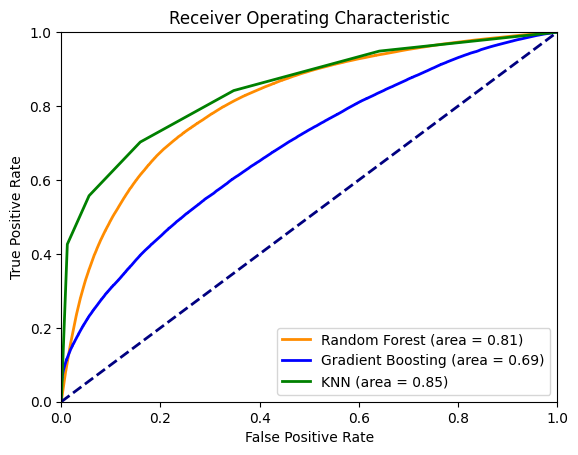

In [39]:

rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_model.predict_proba(X_flight_status_test)[:, 1])
rf_roc_auc = auc(rf_fpr, rf_tpr)

# ROC Curve for Gradient Boosting
gb_fpr, gb_tpr, _ = roc_curve(y_test, gb_model.predict_proba(X_weather_test)[:, 1])
gb_roc_auc = auc(gb_fpr, gb_tpr)

knn_fpr, knn_tpr, _ = roc_curve(y_test, knn_model.predict_proba(X_test_scaled)[:, 1])
knn_roc_auc = auc(knn_fpr, knn_tpr)

# Plot ROC Curves
plt.figure()
plt.plot(rf_fpr, rf_tpr, color='darkorange', lw=2, label='Random Forest (area = %0.2f)' % rf_roc_auc)
plt.plot(gb_fpr, gb_tpr, color='blue', lw=2, label='Gradient Boosting (area = %0.2f)' % gb_roc_auc)
plt.plot(knn_fpr, knn_tpr, color='green', lw=2, label='KNN (area = %0.2f)' % knn_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

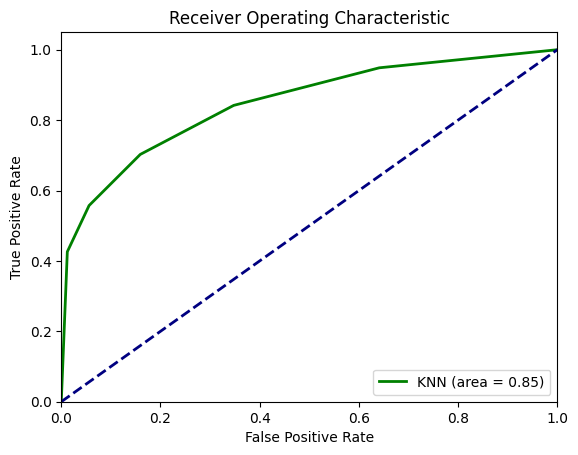

In [40]:
# Calculate ROC curve and AUC for KNN
knn_fpr, knn_tpr, _ = roc_curve(y_test, knn_model.predict_proba(X_test)[:, 1])
knn_roc_auc = auc(knn_fpr, knn_tpr)

# Plot ROC curve for KNN
plt.figure()
plt.plot(knn_fpr, knn_tpr, color='green', lw=2, label='KNN (area = %0.2f)' % knn_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [41]:
# lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_model.predict_proba(X_test_scaled)[:, 1])
# lr_roc_auc = auc(lr_fpr, lr_tpr)

# # Plot ROC curve for Logistic Regression
# plt.figure()
# plt.plot(lr_fpr, lr_tpr, color='purple', lw=2, label='Logistic Regression (area = %0.2f)' % lr_roc_auc)
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic')
# plt.legend(loc="lower right")
# plt.show()

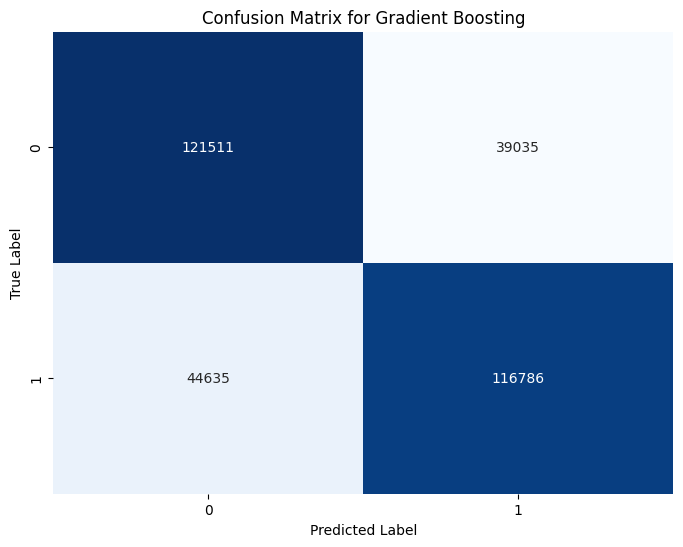

In [42]:
conf_matrix = confusion_matrix(y_test, rf_predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix for Gradient Boosting')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

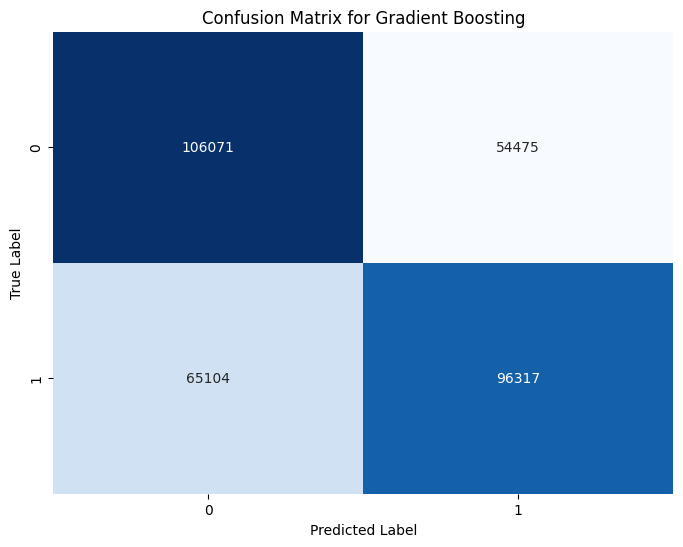

In [43]:
conf_matrix = confusion_matrix(y_test, gb_predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix for Gradient Boosting')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

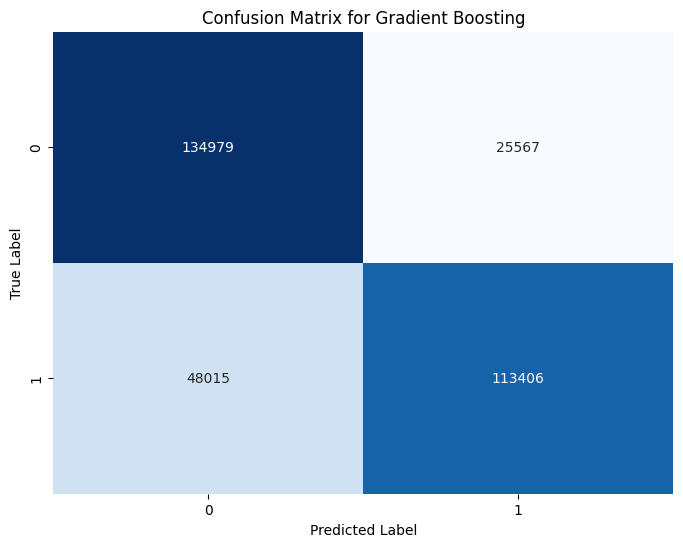

In [44]:
conf_matrix = confusion_matrix(y_test, knn_predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix for Gradient Boosting')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

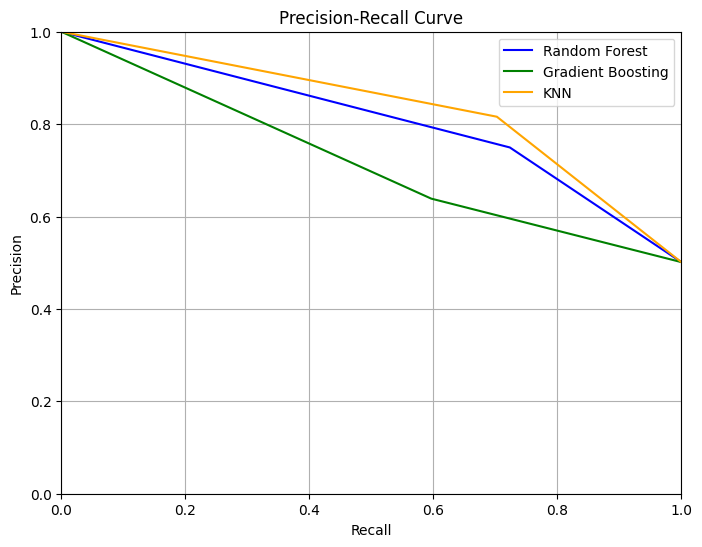

In [45]:
precision_rf, recall_rf, _ = precision_recall_curve(y_test, rf_predictions)
precision_gb, recall_gb, _ = precision_recall_curve(y_test, gb_predictions)
precision_knn, recall_knn, _ = precision_recall_curve(y_test, knn_predictions)


plt.figure(figsize=(8, 6))
plt.plot(recall_rf, precision_rf, color='blue', label='Random Forest')
plt.plot(recall_gb, precision_gb, color='green', label='Gradient Boosting')
plt.plot(recall_knn, precision_knn, color='orange', label='KNN')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.grid()
plt.legend()
plt.show()

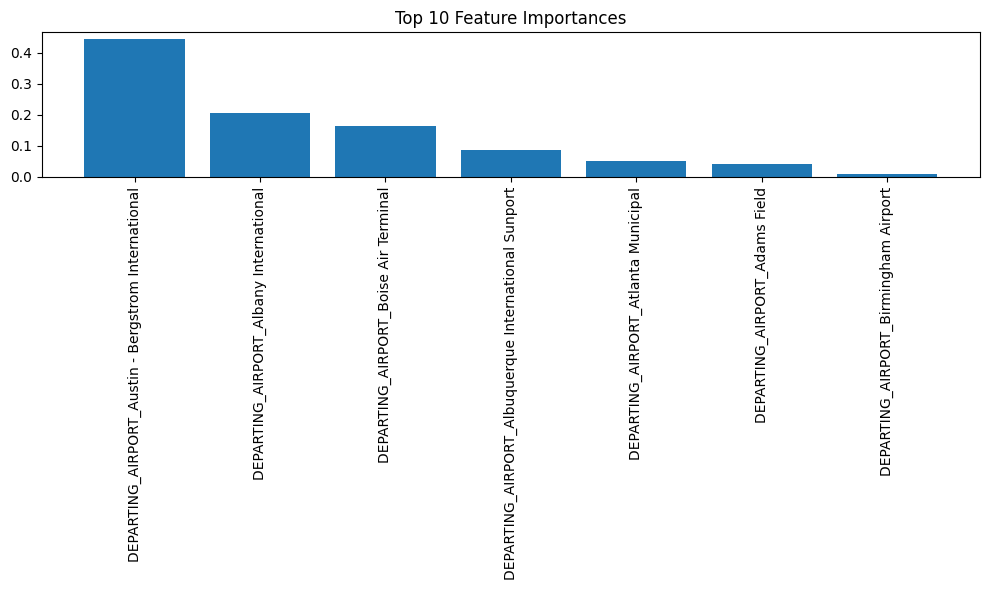

In [46]:
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

top_n = 20
top_indices = indices[:top_n]

# Ensure top_indices does not exceed the length of X.columns
top_indices = [i for i in top_indices if i < len(X.columns)]

plt.figure(figsize=(10, 6))
plt.title("Top 10 Feature Importances")
plt.bar(range(len(top_indices)), importances[top_indices], align="center")
plt.xticks(range(len(top_indices)), X.columns[top_indices], rotation=90)
plt.tight_layout()
plt.show()